# Chapter 6: Real Number Encoding


---

**Prerequisites:**
- See `Chapter02_EngineeringSoftware.ipynb` for installation instructions


In [ ]:
# Setup and imports for D-Wave
import numpy as np
import matplotlib.pyplot as plt
from pyqubo import Binary, Array,Placeholder
from dimod.reference.samplers import ExactSolver
from time import time
import numpy as np
from scipy.stats import ortho_group
from scipy.sparse.linalg import cg
from Chapter03_EngineeringOptimization_functions import TrussFEM, truss3x3
from Chapter05_QuantumAnnealing_functions import print_QUBO_best_result
from Chapter06_RealNumberEncoding_functions import QUBOBoxSolverClass


## Real number encoding example

In [5]:
# Problem data
A = np.array([[2, -1], [-1, 2]])
b = np.array([1, 1])
N = 2
# Exact solution for comparison
x_exact = np.linalg.solve(A, b)
print("Exact solution:", x_exact)
# Box parameters
c = np.array([0, 0])
L = 0.5

# Create binary variables
q1 = Array.create('q1', shape=N, vartype='BINARY')
q2 = Array.create('q2', shape=N, vartype='BINARY')

# Box representation: x = c + L*(-2*q1 + q2)
x = [c[i] + L*(-2*q1[i] + q2[i]) for i in range(N)]

# Potential energy: Pi = 0.5*x^T*A*x - x^T*b
Pi = 0
for i in range(N):
    for j in range(N):
        Pi += 0.5 * A[i,j] * x[i] * x[j]
    Pi -= b[i] * x[i]

# Compile and solve
model = Pi.compile()
bqm = model.to_bqm()


sampler = ExactSolver()
results = sampler.sample(bqm)
q, HMin = print_QUBO_best_result(results,"Exact: ")
# Extract best solution
# Map from q to x using the best solution q
x_best = np.array([c[i] + L*(-2*q[i] + q[i+N]) for i in range(N)])
print(q)
print("Best x:", x_best)


Exact solution: [1. 1.]
Exact:  q values: [0, 0, 1, 1]
Exact:  Lowest Energy: -0.75
[0, 0, 1, 1]
Best x: [0.5 0.5]


## Solve using Box Algorithm

In [10]:
QB = QUBOBoxSolverClass(
	beta=0.5,
	LBox0=1,
	tol=1e-8,
	samplingMethod="simulatedAnnealing",
	nSamples=100,
	boxMaxIteration=100
	)

xSolution, LHistory1, nIterations, _, _, _, _ = QB.QUBOBoxSolve(A, b)
print("xSolution:", xSolution)
print("*" * 50)

xSolution: [1 1]
**************************************************


## 4 x 4 example

$$ \mathbf {A} \mathbf {x} = \mathbf {b} $$


$$ \mathbf {A} =  \begin{bmatrix}
            6 & -6 & 0 & 0 & 0 \\
             -6 & 12 & -6 & 0 & 0 \\
            0 & -6 & 12 & -6 & 0 \\
            0 & 0 & -6 & 12 & -6 \\
             0 & 0 & 0 & -6 & 12 \\
            \end{bmatrix} $$
$$ \mathbf {b}  = \mathbf {A} \begin{pmatrix} \pi/3 \\ -1/2 \\ 1/3 \\ \pi/10 \\ 0.1 \\0.5 \end{pmatrix} $$


In [11]:

A = np.array([[6,-6,0,0,0,0],[-6,12,-6,0,0,0],[0,-6,12,-6,0,0],[0,0,-6,12,-6,0],
		      [0,0,0,-6,12,-6],[0,0,0,0,-6,12]])
xExact = np.array([np.pi/3,-1/2,1/3,-np.pi/10,0.1,0.5 ])
b = A.dot(xExact)

QB = QUBOBoxSolverClass(
	beta=0.5,
	LBox0=1,
	tol=1e-8,
	samplingMethod="simulatedAnnealing",
	nSamples=100,
	boxMaxIteration=100
	)

xSolution, LHistory1, nIterations, _, _, _, _ = QB.QUBOBoxSolve(A, b)
print("xExact:", xExact)
print("xSolution:", xSolution)
print("*" * 50)

xExact: [ 1.04719755 -0.5         0.33333333 -0.31415927  0.1         0.5       ]
xSolution: [ 1.04736328 -0.49975586  0.33349609 -0.31396484  0.10009766  0.5       ]
**************************************************


## Creating Ill-conditioned systems for testing

In [ ]:


def get_test_system(N, p):
    # Kappa = 10^p
    eigenvalues = 10**np.linspace(0, p, N)
    Q = ortho_group.rvs(dim=N)
    A = Q @ np.diag(eigenvalues) @ Q.T
    b = np.random.randn(N)
    b /= np.linalg.norm(b)
    return A, b

# Example loop
N = 8
results = []
for p in [1, 2, 3, 4, 5]:
    A, b = get_test_system(N, p)
    # Perform Box and CG comparisons here...

## QUBO Truss Solver

Numpy time taken (s): 0.0009529590606689453
QUBO time taken (s): 0.8576750755310059
Error:  1.5964575052029046e-08


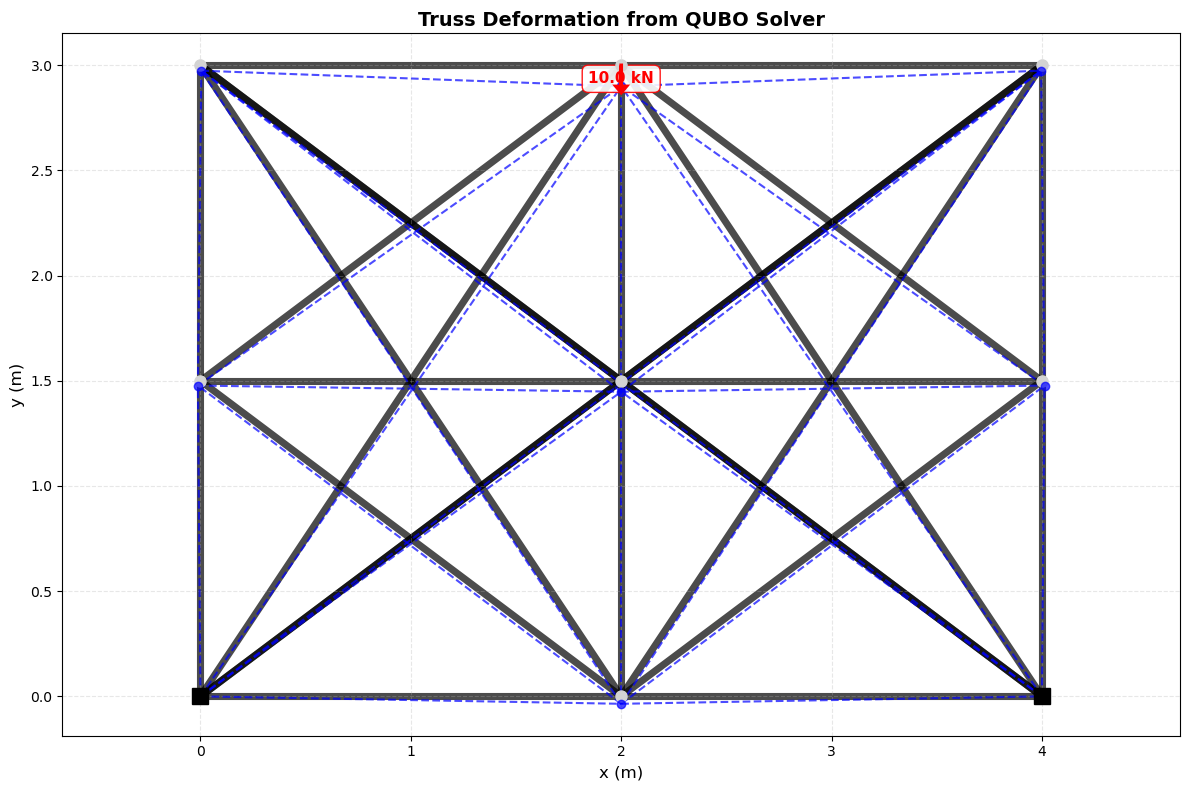

In [4]:
fem_model= truss3x3()

K = fem_model.assemble_stiffness()
all_dofs = set(range(fem_model.n_dofs))
free_dofs = list(all_dofs - set(fem_model.fixed_dofs))
K_free = K[np.ix_(free_dofs, free_dofs)]
f_free = fem_model.loads[free_dofs]

QB = QUBOBoxSolverClass(
	beta=0.3,
	LBox0=1,
	tol=1e-8,
	samplingMethod="simulatedAnnealing",
	nSamples=100,
	boxMaxIteration=100
	)

tStart = time()
d_numpy = np.linalg.solve(K_free, f_free)
print("Numpy time taken (s):", time() - tStart)
tStart = time()
d_QUBO_free, LHistory1, nIterations, _, _, _, _ = QB.QUBOBoxSolve(K_free, f_free)
print("QUBO time taken (s):", time() - tStart)
print("Error: ", np.linalg.norm(d_numpy - d_QUBO_free))
d_QUBO = np.zeros(fem_model.n_dofs)
d_QUBO[free_dofs] = d_QUBO_free 
fem_model.plot_truss(displacements=d_QUBO,title="Truss Deformation from QUBO Solver")